In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
%matplotlib inline

df = pd.read_csv('sac_animals.csv', parse_dates=True)

In [23]:
df.outcome_type.value_counts()
df = df[df['outcome_type'].isin(['ADOPTION' ,'FOSTER', 'RTO', 'EUTH', 'TRANSFER', 'RTF', 'DIED', 'EUTH VET'])]
df = df[df['days_spent'] > 0]

In [24]:
c_data = df[['animal_type', 'animal_sex_clean', 'animal_intake_status', 'name_unknown', 'has_activity_number',
            'animal_age_in_days', 'intake_type', 'color_clean', 'intake_times', 'days_spent']]

x = c_data.drop('days_spent', axis=1)
x = x.apply(LabelEncoder().fit_transform)
y = c_data['days_spent']

In [25]:
c_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21953 entries, 0 to 37350
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   animal_type           21953 non-null  object
 1   animal_sex_clean      21953 non-null  object
 2   animal_intake_status  21953 non-null  object
 3   name_unknown          21953 non-null  int64 
 4   has_activity_number   21953 non-null  int64 
 5   animal_age_in_days    21953 non-null  int64 
 6   intake_type           21953 non-null  object
 7   color_clean           21953 non-null  object
 8   intake_times          21953 non-null  int64 
 9   days_spent            21953 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 1.8+ MB


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=99)

In [5]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, [y.mean()] * len(y_test)))

Mean squared error: 526.01


In [6]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

print('Coefficients: \n', lr.coef_)

print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred_lr))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred_lr))

Coefficients: 
 [ 1.5544432   0.06405618  3.57622503 -3.08650014 -0.07197393  0.15101681
 -0.63954735  0.19273154 -2.88609108]
Mean squared error: 514.26
Coefficient of determination: 0.02


In [7]:
params = {'n_estimators': 100,
          'max_depth': 6,
          'min_samples_split': 5,
          'learning_rate': 0.1,
          'loss': 'ls',
           'random_state': 0}

gbr = GradientBoostingRegressor(**params).fit(x_train, y_train)
y_pred_gbr = gbr.predict(x_test)

print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred_gbr))

print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred_gbr))

Mean squared error: 339.24
Coefficient of determination: 0.36


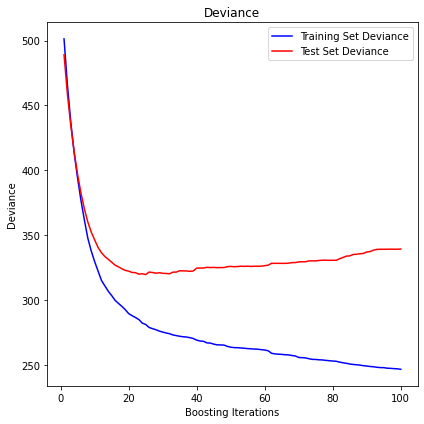

In [8]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(x_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

Looks like we're suffering from overfitting

In [9]:
xgbr = xgb.XGBRegressor(verbosity=1, n_estimators=200, max_depth=10, reg_alpha=0)
xgbr.fit(x_train, y_train)
score = xgbr.score(x_train, y_train)  
print("Training score: ", score)

Training score:  0.6830049212097641


In [10]:
ypred = xgbr.predict(x_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 453.30
RMSE: 21.29


Now it really seems like overfitting

In [11]:
xgb_cv = GridSearchCV(estimator=xgbr, param_grid=dict(max_depth=[2],
                                                     min_child_weight=[7, 8, 9],
                                                     reg_alpha=[0, 0.2, 0.5, 0.7, 0.9],
                                                     reg_lambda=[0, 0.2, 0.5, 0.7, 0.9]),
                         return_train_score=True, scoring='neg_mean_absolute_error')

xgb_cv.fit(x_train, y_train)

results = pd.DataFrame(xgb_cv.cv_results_)
results.sort_values(by='rank_test_score', ascending=True, inplace=True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,param_reg_alpha,param_reg_lambda,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
69,0.175234,0.005199,0.003688,0.000051,2,9,0.7,0.9,"{'max_depth': 2, 'min_child_weight': 9, 'reg_a...",-8.329996,...,-8.561790,0.305061,1,-8.458940,-8.426811,-8.300520,-8.316985,-8.549159,-8.410483,0.092390
4,0.154590,0.011827,0.003352,0.000285,2,7,0,0.9,"{'max_depth': 2, 'min_child_weight': 7, 'reg_a...",-8.344069,...,-8.568902,0.292209,2,-8.482845,-8.424740,-8.284212,-8.320631,-8.562387,-8.414963,0.102403
0,0.150934,0.017190,0.003229,0.000562,2,7,0,0,"{'max_depth': 2, 'min_child_weight': 7, 'reg_a...",-8.372384,...,-8.569361,0.285743,3,-8.498623,-8.413598,-8.278935,-8.306864,-8.577968,-8.415198,0.112925
31,0.177189,0.015566,0.003609,0.000068,2,8,0.2,0.2,"{'max_depth': 2, 'min_child_weight': 8, 'reg_a...",-8.354428,...,-8.569384,0.301718,4,-8.478484,-8.425635,-8.304676,-8.310303,-8.560667,-8.415953,0.098479
64,0.176388,0.002198,0.003713,0.000200,2,9,0.5,0.9,"{'max_depth': 2, 'min_child_weight': 9, 'reg_a...",-8.356716,...,-8.569925,0.300003,5,-8.471729,-8.436682,-8.300547,-8.311878,-8.566934,-8.417554,0.100472


In [13]:
xgb_pred = xgb_cv.predict(x_test)
print(mean_absolute_error(y_test, xgb_pred))

8.704951462266855


In [14]:
import pickle
pickle.dump(xgb_cv, open("sac_animals_predict_days.pkl", 'wb'))

Looks like we have some outliers

It appears rather than the outliers being the problem, the problem might be lack of variance in our data because nearly 70% of our observations fall between 0 and 10 days. How do we solve this? Should we bucket our days seeing this and try to predict using a classifier instead?